In [14]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib import cm
from cmcrameri import cm as cmc # scientific colormaps
import matplotlib.colors as mcolors # for norms
from scipy import ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, ScalarFormatter, NullFormatter)
from collections.abc import Sequence
from typing import Type,Dict,Tuple
import climlab
if True:
    # Get plot settings
    pltfac = 2
    dim = 3.2*pltfac
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 10*pltfac}
    mpl.rc('font', **font)
    lticksmajor = 3*pltfac
    lticksminor = lticksmajor/2
    wticks = lticksmajor/4
    msize = 1.5*(4*pltfac)**2

class params:
    def __init__(self):
        # Specify the case
        self.RHmid   = 0.75
        self.zmid    = 7.5e3
        self.uniform = True
        self.case    = 'ctrl-h2o-RHmid-%d-zmid-%d-uniform-%d'%(self.RHmid*100,self.zmid/1e3,self.uniform)
        # Specify the spectral resolution
        self.nu0      = 10   # cm-1
        self.nu1      = 1500 # cm-1
        self.dnu      = 0.1  # cm-1
        self.crdnu    = 10   # cm-1
        self.band     = 'wv-rot-right' 
        self.runtype  = 'continuum_cooling' 
        self.cp       = 29012/28.964 # J/kg/K
        self.nsday    = 86400 # s
        self.TEMREL   = 0 # ground-air temp diff. (>0 means warmer surface)
        # Identify band coordinates i0,i1
        self.nus = np.arange(self.nu0,self.nu1+self.dnu,self.dnu)
        if self.band=='wv-rot':
            self.i0  = np.squeeze(np.where(self.nus==self.nu0))
            self.i1  = np.squeeze(np.where(np.abs(self.nus-1000)==np.min(np.abs(self.nus-1000))))
        elif self.band=='wv-rot-right':
            self.i0  = np.squeeze(np.where(np.abs(self.nus-150)==np.min(np.abs(self.nus-150))))
            self.i1  = np.squeeze(np.where(np.abs(self.nus-1000)==np.min(np.abs(self.nus-1000))))
        elif self.band=='wv-vib-rot':
            self.i0  = np.squeeze(np.where(np.abs(self.nus-1000)==np.min(np.abs(self.nus-1000))))
            self.i1  = np.squeeze(np.where(np.abs(self.nus-self.nu1)==np.min(np.abs(self.nus-self.nu1))))
        elif self.band=='wv-broadband':
            self.i0  = np.squeeze(np.where(self.nus==self.nu0))
            self.i1  = np.squeeze(np.where(np.abs(self.nus-self.nu1)==np.min(np.abs(self.nus-self.nu1))))
        elif self.band=='co2':
            self.i0  = np.squeeze(np.where(self.nus==self.nu0))
            self.i1  = np.squeeze(np.where(np.abs(self.nus-self.nu1)==np.min(np.abs(self.nus-self.nu1))))
        elif self.band=='ch4':
            self.i0  = np.squeeze(np.where(self.nus==self.nu0))
            self.i1  = np.squeeze(np.where(np.abs(self.nus-self.nu1)==np.min(np.abs(self.nus-self.nu1))))
        self.nnus = len(self.nus)
par = params()
    
import scipy
import pandas as pd
def get_kabs(par,table='tab_h2o.asc')->dict[str,float]:
    #############################################################
    # Fetch the reference absoprtion coefficient
    kabs  = []
    #############################################################
    case  = par.case
    #############################################################
    cwd   = os.getcwd()  # get the current working directory
    fname = os.path.join(cwd, table)
    print(f'processing {fname}')
    with open(fname, 'r') as file:
        for i,line in enumerate(file):  
            line = line.strip()
            if line and i>=10:  # Skip empty lines
                values = line.split()  # Split the line based on whitespace or other delimiters
                # Extract the two columns of data
                column1 = values[0]
                column2 = values[1]
                kabs.append([column1, column2])
    kabs = np.array(kabs)
    kabs = kabs.astype('float')
    kabs = np.exp(kabs)/18 # ln(k)-> k(m2/kmol) -> k(m2/kg)
    kabs = kabs[:,1] 
    #############################################################
    # Compute linear averages of ln(kabs) over coarse bins ("log-averaging") of band j
    lnkabs    = np.log(kabs[par.i0:par.i1+1]) 
    #
    crdnu     = 0.5 # spectral bin-width (cm-1)
    #
    crnus     = np.arange(par.nus[par.i0]+crdnu/2,par.nus[par.i1]+crdnu/2,crdnu)
    bin_edges = np.arange(par.nus[par.i0],par.nus[par.i1]+crdnu,crdnu)
    bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(par.nus[par.i0:par.i1+1], lnkabs, statistic='mean', bins=bin_edges)
    crlnkabs  = bin_means
    crkabs    = np.exp(crlnkabs)
    #############################################################
    # retain only information from band j
    kabs = kabs[par.i0:par.i1+1]
    #############################################################
    if par.band=='wv-vib-rot':
        #############################################################
        # solve least-squares best-fit to crlnkabs and crnus
        # ln(kabs) = m*-(x0-x) + b
        # Subtract x from x0 values
        x0 = 1500 # cm-1
        x_adjusted = -(x0 - crnus)
        # Perform least-squares regression
        A = np.vstack([x_adjusted, np.ones(len(x_adjusted))]).T
        m, b = np.linalg.lstsq(A, crlnkabs, rcond=None)[0]
        print('lvib is',1/m,'cm-1')
        #print('intercept is',np.exp(b))
        bfline = np.exp(-m*(x0-crnus) + b)
        print('kvib=bf-line[0] is',np.exp(b),'m2/kg')
        return {'kabs':kabs,'crkabs':crkabs,'crnus':crnus,'bfline':bfline}
    #############################################################
    elif par.band=='wv-rot-right':
        #############################################################
        # solve least-squares best-fit to crlnkabs and crnus
        # ln(kabs) = m*-(x-x0) + b
        # Subtract x0 from x values
        x0 = 150 # cm-1
        x_adjusted = -(crnus - x0)
        # Perform least-squares regression
        A = np.vstack([x_adjusted, np.ones(len(x_adjusted))]).T
        m, b = np.linalg.lstsq(A, crlnkabs, rcond=None)[0]
        print('lrot is',1/m,'cm-1')
        #print('intercept is',np.exp(b))
        bfline = np.exp(-m*(crnus-x0) + b)
        print('krot=bf-line[0] is',np.exp(b),'m2/kg')
        #############################################################
        # carry out moving average of the residual ("deviation")
        interval = 100 # cm^-1 (bin size)
        step = 25       # cm^-1 (step size for moving window)
        crbfres = []   # Moving averages
        crnures = []   # Interval centers
        # Compute moving average with overlapping bins
        for start in np.arange(par.nus[par.i0]+interval/2, par.nus[par.i1]-interval/2, step):
            # Select data points within the interval
            mask = (par.nus[par.i0:par.i1+1] >= start-interval/2) & (par.nus[par.i0:par.i1+1] < start + interval/2)
            if np.any(mask):
                # Average of true coefficient
                avg_lnkabs = np.mean(np.log(kabs[mask]))
                avg_kabs = np.exp(avg_lnkabs)
                # Wavenumber center of each bin
                numid = start
                crnures.append(numid)
                # Evaluating bfline(numid)
                bf_kabs = np.exp(-m * (numid - x0) + b)
                # Compute the normalized residual
                crbfres.append((avg_kabs - bf_kabs) / bf_kabs)
        # Convert results to arrays
        crbfres = np.array(crbfres)
        crnures = np.array(crnures)
        #############################################################
        return {'kabs':kabs,'crkabs':crkabs,'crnus':crnus,'bfline':bfline,
                'crbfres':crbfres,'crnures':crnures}
    #############################################################
    else: 
        return {'kabs':kabs,'crkabs':crkabs,'crnus':crnus}
    #############################################################
    
    return {'kabs':kabs,'crkabs':crkabs,'crnus':crnus,'counts_per_1d_bin':counts_per_bin,'kref_per_1d_bin':kref_per_bin,
           'ybins':ybins,'xbins':x_bin_edges,'counts_per_2d_bin':counts_per_2d_bin}

processing /home/fspauldinga/SAM24a/RFM/rfmtools/examples/CTRL/h2o-kabs/tab_h2o.asc
lrot is 56.060472099628 cm-1
krot=bf-line[0] is 139.56638388607692 m2/kg
processing /home/fspauldinga/SAM24a/RFM/rfmtools/examples/CTRL/h2o-kabs/tab_h2o_nosub.asc
lrot is 74.36039289482291 cm-1
krot=bf-line[0] is 78.76707567980458 m2/kg
processing /home/fspauldinga/SAM24a/RFM/rfmtools/examples/CTRL/h2o-kabs/tab_h2o.asc
lrot is 56.060472099628 cm-1
krot=bf-line[0] is 139.56638388607692 m2/kg
processing /home/fspauldinga/SAM24a/RFM/rfmtools/examples/CTRL/h2o-kabs/tab_h2o_nosub.asc


/tmp/ipykernel_25716/3360069465.py:92: RuntimeWarning: overflow encountered in exp
  kabs = np.exp(kabs)/18 # ln(k)-> k(m2/kmol) -> k(m2/kg)


lrot is 74.36039289482291 cm-1
krot=bf-line[0] is 78.76707567980458 m2/kg


(-1.0, 10.0)

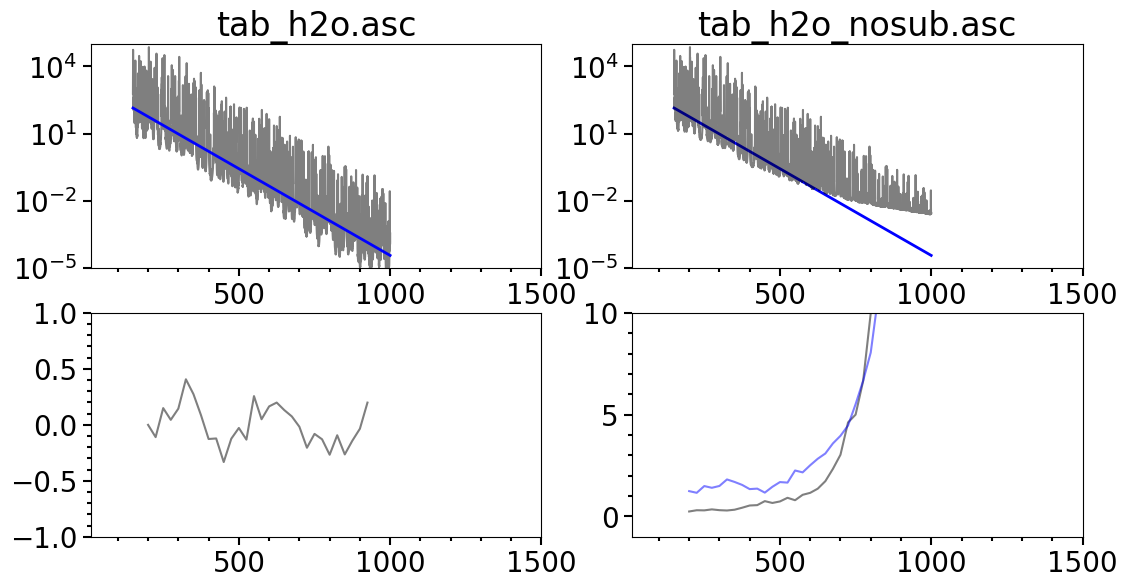

In [20]:
fig, ax = plt.subplots(2,2,figsize=(2*dim,dim))

tables = ['tab_h2o.asc','tab_h2o_nosub.asc']
for i,table in enumerate(tables):
    dat = get_kabs(par,table)
    ax[0,i].plot(par.nus[par.i0:par.i1+1],dat['kabs'],alpha=0.5,color='k')
    ax[0,i].set_xlim([10,1500])
    ax[0,i].set_yscale('log')
    ax[0,i].set_ylim([1e-5,1e5])
    ax[0,i].set_title(table)
    #ax[0,i].plot(dat['crnus'],dat['bfline'],color='b',linestyle='-',linewidth=2)
    
    if i==0:
        ax[0,0].plot(dat['crnus'],dat['bfline'],color='b',linestyle='-',linewidth=2)
        ax[0,1].plot(dat['crnus'],dat['bfline'],color='b',linestyle='-',linewidth=2)
        ax[1,i].plot(dat['crnures'],dat['crbfres'],color='k',linestyle='-',alpha=0.5)
    else:
        datLO    = get_kabs(par,tables[0]) # data from line-only component
        datLOCTM = get_kabs(par,tables[1]) # data from line-only + ctm components
        interval = 100 # cm^-1 (bin size)
        step     = 25       # cm^-1 (step size for moving window)
        xi2      = []
        for start in np.arange(par.nus[par.i0]+interval/2, par.nus[par.i1]-interval/2, step):
            # Select data points within the interval
            mask = (par.nus[par.i0:par.i1+1] >= start-interval/2) & (par.nus[par.i0:par.i1+1] < start + interval/2)
            if np.any(mask):
                # Bin average of true coefficients
                lo_lnkabs = np.mean(np.log(datLO['kabs'][mask]))
                loctm_lnkabs = np.mean(np.log(datLOCTM['kabs'][mask]))
                # 
                lo_kabs    = np.exp(lo_lnkabs)
                loctm_kabs = np.exp(loctm_lnkabs)
                # Compute the deviation of (LO+CTM) and (LO)
                xi2.append((loctm_kabs-lo_kabs)/lo_kabs)
        xi2 = np.array(xi2)
        ax[1,i].plot(dat['crnures'],xi2,color='k',linestyle='-',alpha=0.5)
        ax[1,i].plot(dat['crnures'],(1+xi2)*(1+datLO['crbfres']),color='b',linestyle='-',alpha=0.5)
        
    ax[1,i].set_xlim([10,1500])
    
for i in range(2):
    for j in range(2):
        ax[j,i].tick_params(which='major',length=lticksmajor,width=wticks)
        ax[j,i].tick_params(which='minor',length=lticksminor,width=wticks)
        ax[j,i].yaxis.set_minor_locator(AutoMinorLocator())
        ax[j,i].xaxis.set_minor_locator(AutoMinorLocator())
ax[1,0].set_ylim([-1,1])
ax[1,1].set_ylim([-1,10])

Since $k_{ref} = k_{LLA}(1+\xi_1)$, where $\xi_1$ refers to the deviation of the line-only component from the LLA, we can define a new parameter $\xi_2 = (k_{both} - k_{ref})/(k_{ref})$ which encodes (line+ctm)-(line only), such that $\xi_2$ tells you about the deviation of the ctm part from the line-only part. Together, we arrive at 
$k_{both} = k_{LLA}(1+\xi_1)(1+\xi_2)$, where $\xi_1$ tells you about the deviation of the line-only component from the LLA, and $\xi_2$ tells you about the effect of continuum absorption on the profile.  

We may conclude from the above analysis that the true profile (CTM + LO) is a combination of sinusoidal term (LO part) and an exponentially increasing term (CTM part), which communicates the fact that CTM absorption significantly damps the decay rate of the overall distribution. In particalar, one effect of CTM absorption is to make the water-vapor window region less transparent. This has implications for the CTS approximation, but also for the exchange terms in the lower troposphere. 

In particular, xi2 is incredibly suitable for a power law representation, and requires only a suitable power to be estimated. 

The next step can be considered as: what is the effect of adding CTM absorption to the SSM1D? This will allow us to probe the hypothesis that CTM absorption is important to the existence of a low-cloud mode. One could then test this hypothesis with/without continuum absorption in a CRM. 